# Boston House Prices

&emsp; In order to demonstrate an example notebook workflow, I'm going to do an abridged analysis on the boston house price dataset from `sklearn`. Each record in the dataset is a neighborhood and I'm going to build a model that predicts the mean house price based on the following columns:

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| CRIM        | per capita crime rate by town                          |
| price       | Median value of owner-occupied homes in \$1,000s **(to be predicted)**        |
| TAX         | full-value property-tax rate per $10,000s               |
| AGE         | proportion of owner-occupied units built prior to 1940 |
| RM          | average number of rooms per dwelling                   |
| PTRATIO     | pupil-teacher ratio by town                            |

&emsp; The `autoreload` extension automatically will reload my modules when they are imported so if I edit the `.py` files I don't need to restart the kernel.

In [1]:
%load_ext autoreload
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import load, investigate, featureCreate, model

df = (
    load.importDat(['CRIM', 'price', 'TAX', 'AGE', 'RM', 'PTRATIO'])
    # Whatever other preprocessing needs to happen
)
df.describe()

,CRIM,price,TAX,AGE,RM,PTRATIO
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,22.532806,408.237154,68.574901,6.284634,18.455534
std,8.601545,9.197104,168.537116,28.148861,0.702617,2.164946
min,0.006320,5.000000,187.000000,2.900000,3.561000,12.600000
25%,0.082045,17.025000,279.000000,45.025000,5.885500,17.400000
50%,0.256510,21.200000,330.000000,77.500000,6.208500,19.050000
75%,3.677083,25.000000,666.000000,94.075000,6.623500,20.200000
max,88.976200,50.000000,711.000000,100.000000,8.780000,22.000000


&emsp; This dataset has 506 rows and the above table contains some descriptive statistics. Now I'll do a quick check for missing values.

In [3]:
df.isna().sum()

CRIM       0
price      0
TAX        0
AGE        0
RM         0
PTRATIO    0
dtype: int64

&emsp; Looks like there aren't any missing values. Lets take a look at the distributions of the pairs of variables.

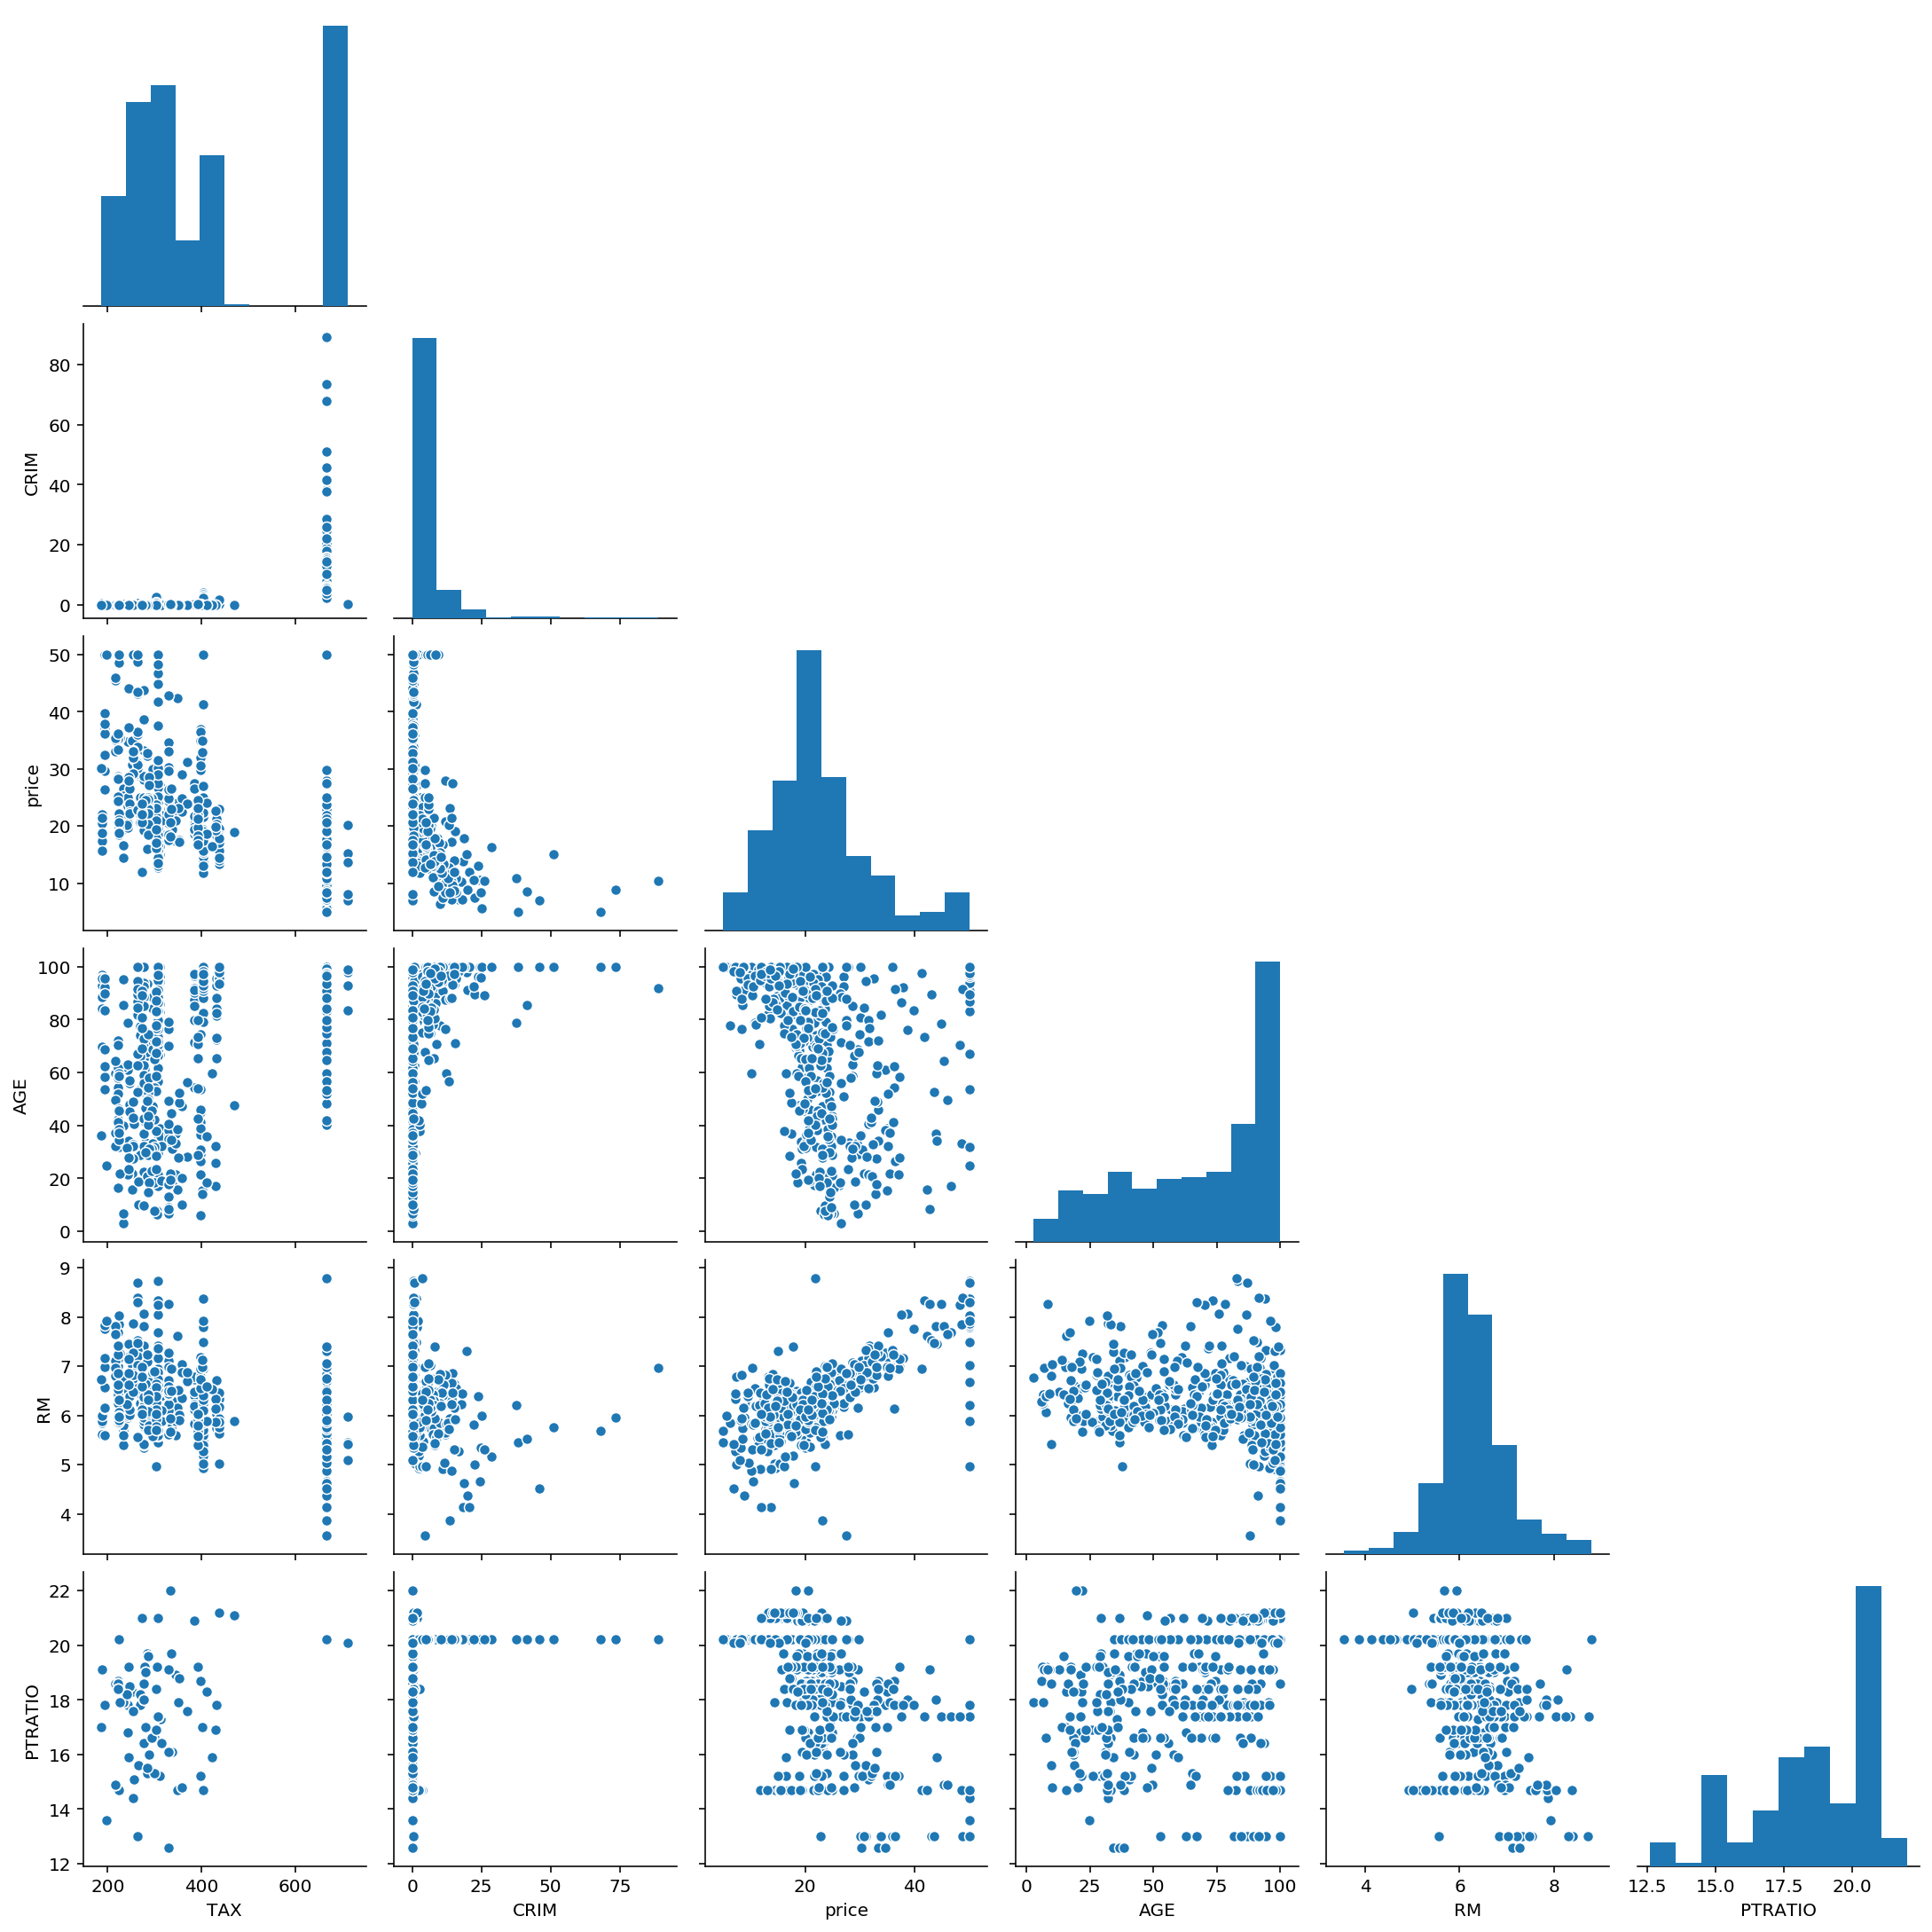

In [4]:
sns.pairplot(
    df[['TAX', 'CRIM', 'price', 'AGE', 'RM', 'PTRATIO']], 
    corner=True
);

A couple notes on this plot:

- `AGE` shows quite a bif of left skewness (lots of old houses in boston)
- `price` and `RM` are positively correlated (this is good to see), and it seems like `price` has been capped at 60k
- The scatter plot between `PRATIO` and `TAX` only shows 2 points with `TAX` over 600, this doesn't seem right and will be investigated further
- `CRIM` seems to only be greater than 0 in areas with a `PTRATIO` of around 20

<br>

Let's investigate the plot between `TAX` and `PTRATIO` a tad bit further.

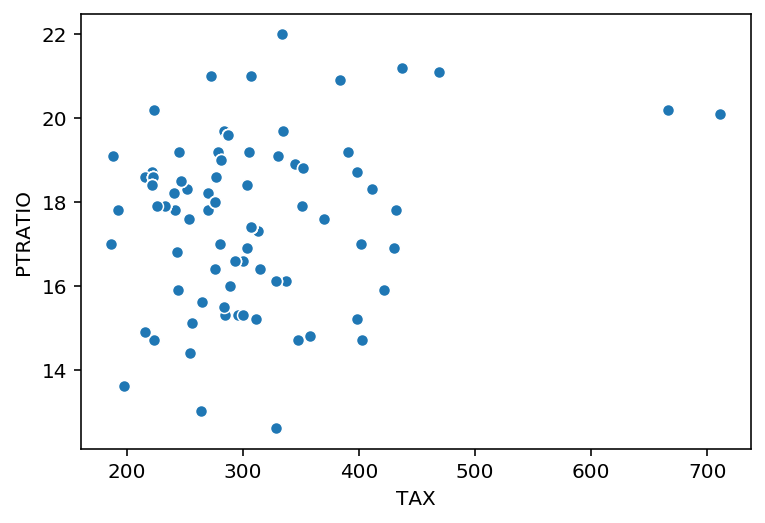

In [5]:
sns.scatterplot(df['TAX'], df['PTRATIO']);

In [6]:
df[df['TAX'] > 600].shape[0]

137

&emsp; How come the scatter plot only shows 2 points above 600 for `TAX`? After some further investigating, it appears that those "2 points" are actually a lot more, but they're just stacked on top of each other. Counting the distinct combinations of `TAX` and `PTRATIO` for `TAX` over 600 would be helpful.

In [7]:
investigate.taxPratio(df)

,TAX,PTRATIO,count
0,666.0,20.2,132
1,711.0,20.1,5


&emsp; And here lies the issue. It's clear there are actually 137 points hiding in those 2 circles on the scatter plot. Now we'll look at the correlation between the variables.

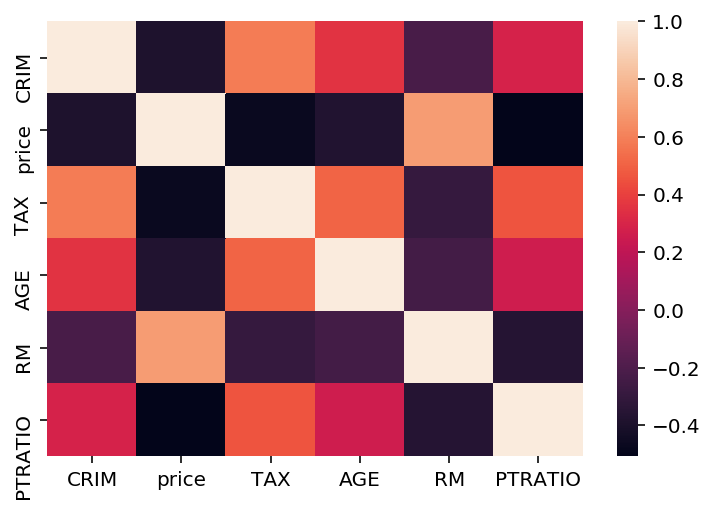

In [8]:
sns.heatmap(df.corr());

&emsp; It appears that `price` and `PTRATIO` are negatively correlated. This makes sense, as I would expect more expensive neighborhoods to have smaller classrooms (which some people think means the education is better but I won't draw that conclusion here).

&emsp; Another thing to note is that `RM` and `price` are positively correlated. This also makes sense because I would expect larger houses to have higher prices.

# Modeling

&emsp; No relationships in the scatter matrix suggested that there are any non-linear patterns, so I'll proceed by using a ordinary least squares model with no squared terms.

                               OLS Using Normalized Data                               
Dep. Variable:                  price   R-squared (uncentered):                   0.612
Model:                            OLS   Adj. R-squared (uncentered):              0.609
Method:                 Least Squares   F-statistic:                              158.3
Date:                Sun, 15 Mar 2020   Prob (F-statistic):                   1.09e-100
Time:                        09:50:45   Log-Likelihood:                         -477.66
No. Observations:                 506   AIC:                                      965.3
Df Residuals:                     501   BIC:                                      986.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

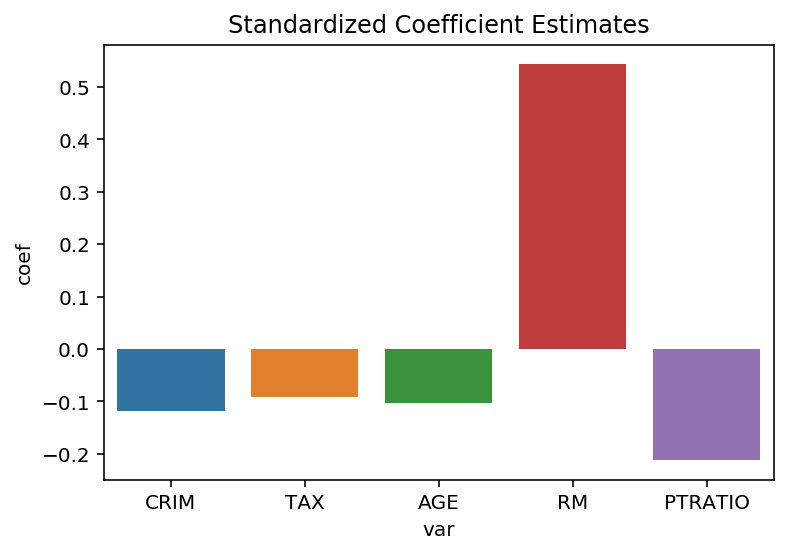

In [9]:
olsModel = model.slr(featureCreate.normalize(df),
                     xVars=[x for x in df.columns if x != 'price'],
                     yVar='price')
print(olsModel.summary(title='OLS Using Normalized Data'))

sns.barplot(x = 'var', y='coef', data=model.getCoefs(olsModel));
plt.title('Standardized Coefficient Estimates');

&emsp; Each additional room a house has has the largest affect on the price of a house, this is not very surprising. Note that `CRIM`, `TAX`, and `AGE` are all negative, and `PTRATIO` appears to be the most negative, almost twice as negative as `AGE`. Approximately 60% of the variation in median price is being explained by this model.

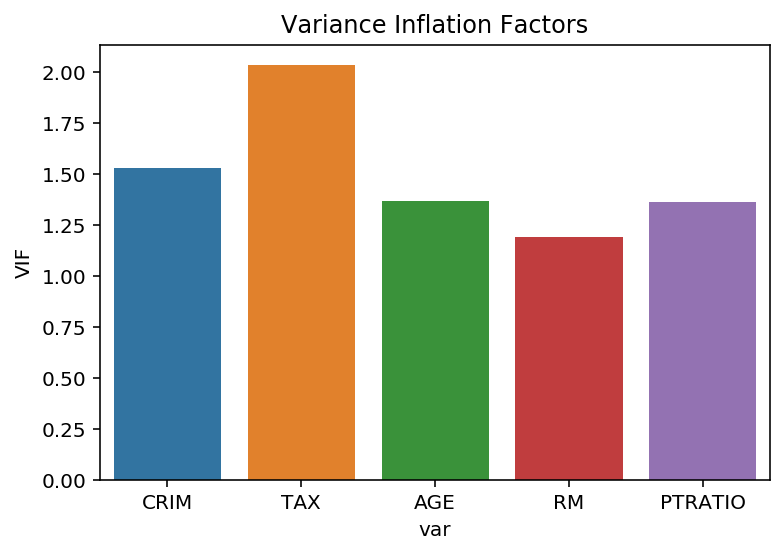

In [10]:
model.getVIF(df[['CRIM', 'TAX', 'AGE', 'RM', 'PTRATIO']]);
plt.title('Variance Inflation Factors');

&emsp; Above are the variance inflation factors for each x variable in the model. The `getVIF` function can also return the VIFs as a dataframe.

In [11]:
model.getVIF(df[['CRIM', 'TAX', 'AGE', 'RM', 'PTRATIO']], plot=False)

,var,VIF
0,CRIM,1.529360
1,TAX,2.033157
2,AGE,1.369993
3,RM,1.188927
4,PTRATIO,1.362231


# Analyzing Outliers

&emsp; We've created our model but now it's time to see if there are any individual data points that are affecting the model fit.

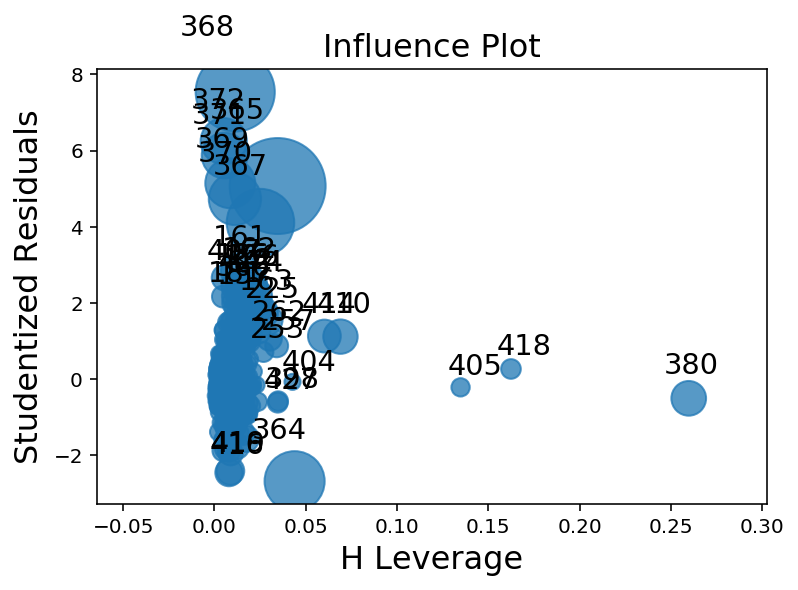

In [12]:
model.getPlot(olsModel)

&emsp; The plot above shows the leverage of each point as well as the studentized residual for each record. I'm going to stop the train here, as a conversation about influential points really warrants its own analysis/post. For now I'll just demonstrate identifying records that have leverage above .10.

In [13]:
model.getDFB(olsModel).query('hat_diag > .10')

,dfb_CRIM,dfb_TAX,dfb_AGE,dfb_RM,dfb_PTRATIO,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
380,-0.299087,0.106731,0.016623,-0.056784,-0.009795,0.018606,-0.514808,0.259820,-0.305009,-0.514430,-0.304785
405,-0.087355,0.030896,0.002833,-0.000273,0.001153,0.001591,-0.225925,0.134827,-0.089187,-0.225711,-0.089103
418,0.111641,-0.040132,-0.003505,0.006137,-0.000102,0.002576,0.257711,0.162441,0.113494,0.257471,0.113388


This table contains lots of useful diagnostics for detecting outliers including:

- DFBetas
- Cook's D
- Standardized residuals
- Hat diagonals (leverage)
- DFFits

# Summary

&emsp; This post demonstrates an example analysis workflow that I'd like to keep tweaking. By keeping most of the more granular code in modules I can keep the notebook as clean as possible.